# Amazon Dataset - Data Preprocessing

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import re
from bs4 import BeautifulSoup
import emoji
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import unicodedata
import contractions
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

[nltk_data] Error loading stopwords: [WinError 10054] An existing
[nltk_data]     connection was forcibly closed by the remote host
[nltk_data] Downloading package punkt_tab to C:\Users\Mohamed
[nltk_data]     Kamal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 1. Data Loading and First Level Cleaning (Structural Cleaning)

In [2]:
df_amazon_all_features =  pd.read_csv(r'../../p1_data/raw/amazon.csv')
df_amazon_all_features.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# Since we are focusing on sentiment analysis (positive or negative), we only need the Score and Text columns.
df_amazon = pd.read_csv(
    r'../../p1_data/raw/amazon.csv',
    usecols=['Score', 'Text']
)
df_amazon.columns = ['label', 'review']

original_length = len(df_amazon)
df_amazon.head()

,label,review
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [4]:
df_amazon.shape

(568454, 2)

In [5]:
df_amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   568454 non-null  int64 
 1   review  568454 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.7+ MB


In [6]:
df_amazon["label"].value_counts()

label
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

In [7]:
# To calcultate the total number of removed recordes
total_removed_recordes = 0 

In [8]:
#Check duplicate values 
dup_data = float(df_amazon.duplicated().sum())

if dup_data > 0:
    print(f"The number of duplicated records in the data is {dup_data} where the total percentage of duplicated values is {dup_data/len(df_amazon)*100}%")
    print("\nSample duplicate rows:")
    display(df_amazon[df_amazon.duplicated()].head())
else:
    print("No duplication in the data")

The number of duplicated records in the data is 174779.0 where the total percentage of duplicated values is 30.746375256397172%

Sample duplicate rows:


,label,review
29,5,I don't know if it's the cactus or the tequila...
574,5,"I'm addicted to salty and tangy flavors, so wh..."
603,5,"I'm addicted to salty and tangy flavors, so wh..."
1973,3,The pork chops from Omaha Steaks were very tas...
2309,2,Too much of the white pith on this orange peel...


In [9]:
before = len(df_amazon)

df_amazon = df_amazon.drop_duplicates()

after = len(df_amazon)
total_removed_recordes += before - after

print(f"Removed {before - after}")
print(f"Total removed recordes: {total_removed_recordes}")

Removed 174779
Total removed recordes: 174779


In [10]:
#Check null (missing) values and null (missing) percentage

In [11]:
#Check null (missing) values and null (missing) percentage
null_values_per_feature = df_amazon.isnull().sum()

if null_values_per_feature.sum() > 0:
    i = 1
    for feature, value in null_values_per_feature.items():
        print(f"Feature {i}: '{feature}' has {value} null values whose percentage is {df_amazon[feature].isnull().sum()}% from the total values of the data for this feature")
        i+=1
else:
    print("No Nulls in the data")

No Nulls in the data


In [12]:
first_level_cleaning_train = {"Dataset":["Amazon"],"Original Size":[original_length],"Cleaned Size":[len(df_amazon)],"Removed Rows":[total_removed_recordes]}
df_first_level_cleaning_train = pd.DataFrame(first_level_cleaning_train)
df_first_level_cleaning_train

,Dataset,Original Size,Cleaned Size,Removed Rows
0,Amazon,568454,393675,174779


In [13]:
df_amazon.to_csv("../../p1_data/cleaned/amazon_1st_level_clean.csv", index=False)

## 2. Label Encoding

In [14]:
# Since there is no dedicated column to indicate polarity (+ve or -ve), we rely on the Score column to determine it.
"""
changing the negative scores/labels '1' and '2' to the label '0'
changing the positive scores/labels '4'and '5' to the label '1'
keeping the neutral scores/labels '3' (42,640 records will be removed later to prevent the model from producing misleading results.)
"""

df_amazon['label'] = df_amazon['label'].replace({
    1: 0,
    2: 0,
    4: 1,
    5: 1})

#check the updated labels
df_amazon.head(10)

,label,review
0,1,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,1,Great taffy at a great price. There was a wid...
5,1,I got a wild hair for taffy and ordered this f...
6,1,This saltwater taffy had great flavors and was...
7,1,This taffy is so good. It is very soft and ch...
8,1,Right now I'm mostly just sprouting this so my...
9,1,This is a very healthy dog food. Good for thei...


In [15]:
#Check appearance of duplicates after encoding since we unify the label for some rows
dup_data = float(df_amazon.duplicated().sum())

if dup_data > 0:
    print(f"The number of duplicated records in the data is {dup_data} where the total percentage of duplicated values is {dup_data/len(df_amazon)*100}%")
    print("\nSample duplicate rows:")
    display(df_amazon[df_amazon.duplicated()].head())
else:
    print("No duplication in the data")

The number of duplicated records in the data is 62.0 where the total percentage of duplicated values is 0.015749031561567282%

Sample duplicate rows:


,label,review
16304,1,Delicious cup of coffee. This is not the best ...
20479,1,This is an edit so I was unable to change my s...
55643,1,"Very tasty. I like Honey-Nut Cheerios, and the..."
72210,1,This is a great substitute if you're vegetaria...
77646,1,"I have long been a fan of mixing juice, such a..."


In [16]:
before = len(df_amazon)

df_amazon = df_amazon.drop_duplicates()

after = len(df_amazon)
total_removed_recordes += before - after

print(f"Removed {before - after}")
print(f"Total removed recordes: {total_removed_recordes}")

Removed 62
Total removed recordes: 174841


## 3. Exploratory Data Analysis (EDA)

In [17]:
# Printing Random Samples

In [18]:
for label in df_amazon["label"].unique():
    print(f"\n=== Samples from class {label} ===")
    samples = df_amazon[df_amazon["label"] == label].sample(3, random_state=42)
    for r in samples["review"].values:
        print("-", r[:300], "...")  # print first 300 chars only


=== Samples from class 1 ===
- If you failed to purchase enough of the Mint Girl Scout Cookies this year, well, this is definitely your day! Keebler used to make the mint cookies for the scouts and one bite of these guys and you'll be astonished at the similarity! The cookie is chocolate, as is the fudge icing, and they're SO won ...
- I have always been a chocolate covered peanuts fan, but I must say that all too often I have been disappointed with the quality of them. Sometimes you open a bag, and find that the peanuts are rancid, absolutely destroying the taste, or the chocolate is of poor quality, or what have you. But, for wh ...
- Awesomely easy cup of tea. For an extra dose of self satisfaction, add a squirt of whipped cream!<br /><br />Chai tea is also good for you so drink up. ...

=== Samples from class 0 ===
- I love flavored tea, especially tea mixed with fruit flavors. The mixes that I like in this particular Lipton Pyramid Teabag series, include Bavarian Wild Berries, Wh

### Working with Label Column

In [19]:
#Count values of each Label (Class Distribution) and their ratios
df_amazon["label"].nunique()

3

In [20]:
counts_per_label = df_amazon["label"].value_counts().sort_index()
for label, count in counts_per_label.items():
    print(f"Label '{label}' has {count} records, with percetange of {count/counts_per_label.sum()*100}% from the total records")

Label '0' has 57073 records, with percetange of 14.499775159865147% from the total records
Label '1' has 306768 records, with percetange of 77.93645026968113% from the total records
Label '3' has 29772 records, with percetange of 7.56377457045372% from the total records


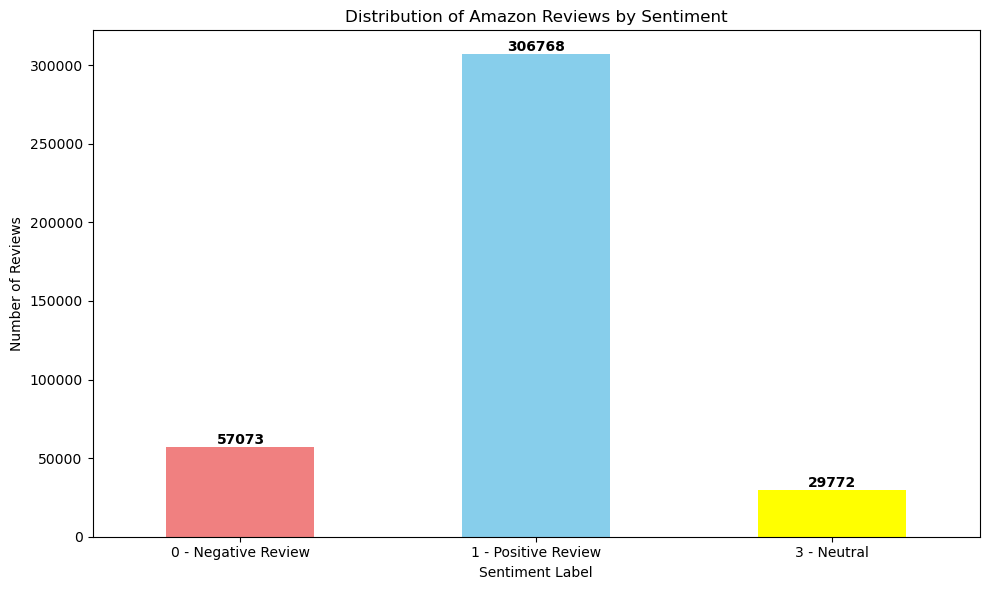

In [21]:
#Plotting Class Distribution of Training Data using bar chart
plt.figure(figsize=(10, 6))
plot = counts_per_label.plot(kind = 'bar', color = ['lightcoral', 'skyblue', 'yellow'])
plot.set_xticklabels(["0 - Negative Review", "1 - Positive Review", "3 - Neutral"])
plt.title('Distribution of Amazon Reviews by Sentiment')
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.tight_layout()


# Add value labels on bars
for i, v in enumerate(counts_per_label):
    plot.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

plt.show()

## 4. Text Cleaning

### Working with Review Column (Text Data)

In [22]:
df_amazon.head()

,label,review
0,1,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,1,Great taffy at a great price. There was a wid...


In [23]:
stop_words = set(stopwords.words('english'))

def cleaned_review(review):

    # Handle NaN/None values
    if pd.isna(review):
        return ""

    # 1. Expand contractions using the contractions library
    review = contractions.fix(review)
    
    # 2. Remove accents (Café → Cafe)
    review =  unicodedata.normalize("NFKD", str(review)).encode("ascii", "ignore").decode("utf-8", "ignore")
    
    # 3. Remove URLs
    review = re.sub(r'http\S+|www\S+|https\S+', '', review, flags=re.MULTILINE)
    
    # 4. Remove HTML tags
    review = BeautifulSoup(review, "html.parser").get_text()
    
    # 5. Remove emojis and special characters (keep only letters and basic punctuation)
    review = re.sub(r'[^a-zA-Z\s\.\,\!\?]', '', review)
    
    # 6. Convert to lowercase
    review = review.lower()
    
    # 7. Replace non-letters WITH A SPACE
    review = re.sub(r'[^a-zA-Z\s]', ' ', review)
    
    # 8. Remove extra whitespace (replace multiple spaces with a single space)
    review = re.sub(r'\s+', ' ', review)
    
    # 9. Strip leading/trailing spaces
    review = review.strip()
    
    # 10. Remove stop words
    tokenized_review = word_tokenize(review)
    review_no_stop_words = [word for word in tokenized_review if word not in stop_words]
    review = ' '.join(review_no_stop_words)

    return review
    
df_amazon["cleaned_review"] = df_amazon["review"].apply(cleaned_review)

C:\Users\Mohamed Kamal\AppData\Local\Temp\ipykernel_1308\2511454693.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review, "html.parser").get_text()


In [24]:
df_amazon.head()

,label,review,cleaned_review
0,1,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,0,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...
2,1,This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,0,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,1,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...


In [25]:
#Summary statistics of words and chars per review before cleaning
lengths_of_reviews_words = df_amazon["review_word_count"] = df_amazon['review'].apply(lambda x : len(x.split()))
lengths_of_reviews_chars = df_amazon["review_char_count"] = df_amazon['review'].apply(lambda x : len(x))
print(f"Summary Statistics for # of words per review \n{lengths_of_reviews_words.describe()}", sep="-")
print("___________________________")
print(f"Summary Statistics for # of chars per review \n{lengths_of_reviews_chars.describe()}")
print("________________________________________________________________________________")
print("________________________________________________________________________________")
print("________________________________________________________________________________")
#Summary statistics of words and chars per review after cleaning
lengths_of_reviews_words_cleaned = df_amazon["review_word_count_cleaned"] = df_amazon['cleaned_review'].apply(lambda x : len(x.split()))
lengths_of_reviews_chars_cleaned = df_amazon["review_char_count_cleaned"] = df_amazon['cleaned_review'].apply(lambda x : len(x))
print(f"Summary Statistics for # of words per review \n{lengths_of_reviews_words_cleaned.describe()}")
print("___________________________")
print(f"Summary Statistics for # of chars per review \n{lengths_of_reviews_chars_cleaned.describe()}")

Summary Statistics for # of words per review 
count    393613.000000
mean         79.759083
std          77.168186
min           3.000000
25%          34.000000
50%          57.000000
75%          97.000000
max        3432.000000
Name: review, dtype: float64
___________________________
Summary Statistics for # of chars per review 
count    393613.000000
mean        433.864222
std         433.037387
min          12.000000
25%         181.000000
50%         304.000000
75%         527.000000
max       21409.000000
Name: review, dtype: float64
________________________________________________________________________________
________________________________________________________________________________
________________________________________________________________________________
Summary Statistics for # of words per review 
count    393613.000000
mean         38.703117
std          37.777927
min           0.000000
25%          17.000000
50%          27.000000
75%          47.000000
max 

In [26]:
# Before 
df_amazon['review'][1]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

In [27]:
# After
df_amazon['cleaned_review'][1]

'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo'

In [28]:
# Now, we need to find rows where review after cleaning becomes duplicated
dup_data = df_amazon[["label", "cleaned_review"]].duplicated().sum()


if dup_data > 0:
    print(f"The number of duplicated records in the data is {dup_data} where the total percentage of duplicated values is {dup_data/len(df_amazon)*100}%")
    print("\nSample duplicate rows:")
    display(df_amazon[df_amazon[["label", "cleaned_review"]].duplicated()].sort_values('cleaned_review'))
else:
    print("No duplication in the data")

The number of duplicated records in the data is 613 where the total percentage of duplicated values is 0.15573672617520254%

Sample duplicate rows:


,label,review,cleaned_review,review_word_count,review_char_count,review_word_count_cleaned,review_char_count_cleaned
253111,1,"<a href=""http://www.amazon.com/gp/product/B000...",,46,367,0,0
233938,1,&#1056;&#1077;&#1096;&#1080;&#1083;&#1072; &#1...,,27,979,0,0
540697,1,"<a href=""http://www.amazon.com/gp/product/B001...",,76,552,0,0
552994,1,"<a href=""http://www.amazon.com/gp/product/B000...",,130,946,0,0
386557,1,"<a href=""http://www.amazon.com/gp/product/B001...",,222,1348,0,0
...,...,...,...,...,...,...,...
508818,0,Over the years my parents would send me to sch...,years parents would send school fine usually e...,596,3337,311,2146
331323,0,"Yes, I know, I know, agave nectar is supposed ...",yes know know agave nectar supposed answer see...,550,3537,321,2386
111966,1,"Yes, these olives remind me of my vacation to ...",yes olives remind vacation europe know live ea...,71,355,37,215
336029,1,"Yummy, yummy!<br />This curry paste is now my ...",yummy yummy curry paste favorite easy use stor...,175,929,86,544


In [29]:
before = len(df_amazon)

df_amazon = df_amazon[~df_amazon[["label", "cleaned_review"]].duplicated()]

after = len(df_amazon)
total_removed_recordes += before - after

print(f"Removed {before - after}")
print(f"Total removed recordes: {total_removed_recordes}")

Removed 613
Total removed recordes: 175454


In [30]:
# Now, we need to find rows where review is duplicated, but the full row is not (AKA: same review different sentiment)
mask = df_amazon['cleaned_review'].duplicated(keep=False) & ~df_amazon[['cleaned_review', 'label']].duplicated(keep=False)
df_amazon[mask].sort_values('cleaned_review')

,label,review,cleaned_review,review_word_count,review_char_count,review_word_count_cleaned,review_char_count_cleaned
206909,1,"<a href=""http://www.amazon.com/gp/product/B000...",,63,482,0,0
294529,0,"<a href=""http://www.amazon.com/gp/product/B000...",,95,651,0,0
129481,1,I agree with some of the other reviewers (for ...,agree reviewers nonclassic syrup buying produc...,117,633,52,353
385750,3,I agree with some of the other reviewers (for ...,agree reviewers nonclassic syrup buying produc...,117,633,52,353
342830,1,These beans were very economical and the selle...,beans economical seller extremely prompt getti...,49,258,19,137
...,...,...,...,...,...,...,...
402007,3,tried Wolfgang and Baronet coffees after Sense...,tried wolfgang baronet coffees senseo brand co...,27,166,19,123
459283,1,"The Typhoo Decaf is decent tea, but not great....",typhoo decaf decent tea great also tried pg ti...,31,178,20,128
261495,3,"The Typhoo Decaf is decent tea, but not great....",typhoo decaf decent tea great also tried pg ti...,31,178,20,128
399817,3,"Through the years, I've tried just about every...",years tried every premade coffee beverage imag...,365,2038,169,1218


In [31]:
"""
Since the same review appears once as [+ve, -ve] and once as undecided (score = 3), or once as positive and once as negative
we remove both instances(74 records) to prevent the model from producing misleading results.
label  count
    3     36
    1     25
    0     13
"""
before = len(df_amazon)

df_amazon = df_amazon[~mask]

after = len(df_amazon)
total_removed_recordes += before - after

print(f"Removed {before - after}")
print(f"Total removed recordes: {total_removed_recordes}")

Removed 110
Total removed recordes: 175564


In [32]:
# ...
# Removing the remaining records where score == 3

before = len(df_amazon)

df_amazon = df_amazon.query("label != 3")

after = len(df_amazon)
total_removed_recordes += before - after

print(f"Removed {before - after}")
print(f"Total removed recordes: {total_removed_recordes}")

Removed 29685
Total removed recordes: 205249


In [33]:
# Duplicated records?
df_amazon[['cleaned_review', 'label']].duplicated().sum()

np.int64(0)

In [34]:
df_amazon['cleaned_review'].duplicated().sum()

np.int64(0)

In [35]:
df_amazon[['review_word_count', 'review_word_count_cleaned']].describe()

,review_word_count,review_word_count_cleaned
count,363205.000000,363205.000000
mean,78.279768,38.050861
std,75.741277,37.100996
min,3.000000,1.000000
25%,33.000000,16.000000
50%,56.000000,27.000000
75%,95.000000,46.000000
max,2520.000000,1479.000000


In [36]:
df_amazon[['review_char_count', 'review_char_count_cleaned']].describe()

,review_char_count,review_char_count_cleaned
count,363205.000000,363205.000000
mean,425.661414,253.043838
std,424.589542,253.487398
min,12.000000,3.000000
25%,179.000000,107.000000
50%,298.000000,178.000000
75%,516.000000,307.000000
max,16952.000000,10970.000000


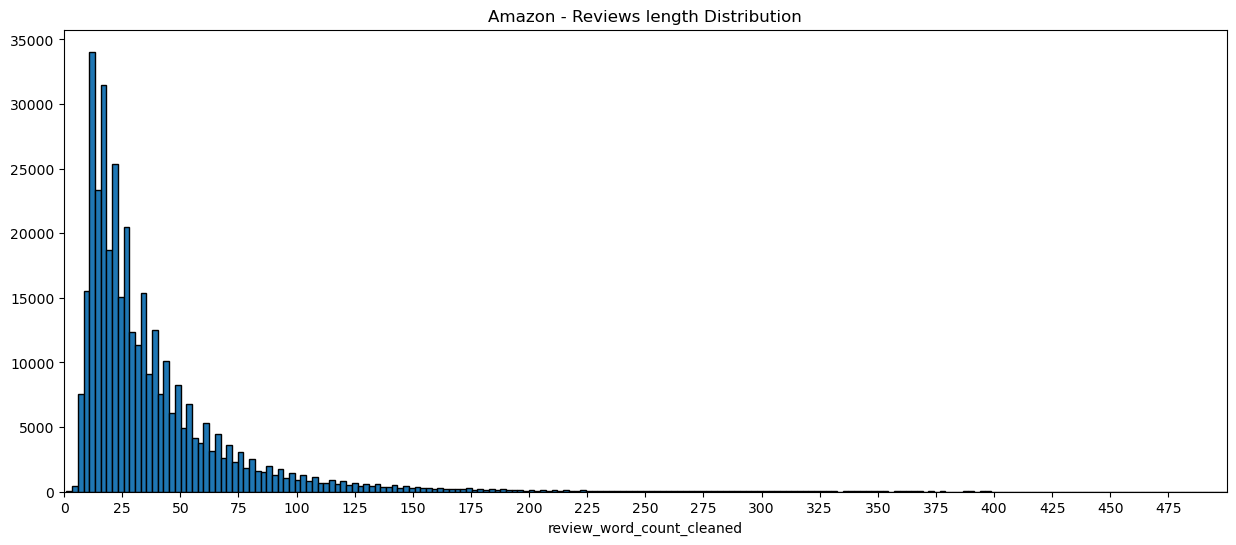

In [37]:
n = len(df_amazon['review_word_count_cleaned'])
bins = int(np.sqrt(n))

plt.figure(figsize=(15, 6))

plt.hist(df_amazon['review_word_count_cleaned'], bins=bins, edgecolor="black")

plt.title("Amazon - Reviews length Distribution")
plt.xlabel("review_word_count_cleaned")
plt.xlim(0, 500) 
plt.xticks(np.arange(0, 500, 25))
plt.show()

## Sample of original and cleaned text

In [38]:
# To show full text in pandas output:
pd.set_option("display.max_colwidth", None)

# To reset back to default later:
# pd.reset_option("display.max_colwidth")

In [39]:
sample_idx = df_amazon.sample(5).index

In [40]:
df_amazon.loc[sample_idx, ['review']]

,review
78840,When I opened the box a good portion of the product had leaked through HOLES throughout the bag. As far as I am concerned this product is GARBAGE bc they won't let me return it. I'm not ingesting an open bag of product. It was an expensive lesson!
25848,"I bought these peppercorns to make Asian dan dan noodles and the noodles came out great. The peppercorns add a definite spicy flavor, very tasty for those who like spicy foods. Will plan to include these peppercorns in more dishes."
228600,"It's Chicken. It's in a Biskit. Do I need to say more?<br /><br />If you could turn awesome into a cracker, it would be C in a B.<br /><br />If Chuck Norris was edible, he'd be C in a B.<br /><br />Under certain congressional definitions C in a B contains all four food groups when eaten with Easy Cheese.<br /><br />Like I said above: It's Chicken...in a Biskit."
20120,"Have been using this litter for years. Used to be able to find it in stores, becoming more and more difficult tho. It's better than Worlds Best because it never becomes ""gluey"" when wet. Clumps beautifully, easy to scoop, and in my opinion, probably the healthiest litter out there. Cats love it, grains are not sharp at all."
111470,"After receiving a gift of delicious blueberry preserves from a speciality store, I set out to find something similar in my local supermarket; in particular, I was looking for a product made from wild blueberries. Bonne Maman's Wild Blueberry Perserves turned out to be exactly what I wanted! It's a very sweet jam that includes whole wild blueberries (which are smaller than regular blueberries) in every spoonful. The preserves are easily spreadable and are great on toast, but I've also found that they are wonderful for adding to plain yogurt or smoothies. A delicious must-have for blueberry lovers!"


In [41]:
df_amazon.loc[sample_idx, ['cleaned_review']]

,cleaned_review
78840,opened box good portion product leaked holes throughout bag far concerned product garbage let return ingesting open bag product expensive lesson
25848,bought peppercorns make asian dan dan noodles noodles came great peppercorns add definite spicy flavor tasty like spicy foods plan include peppercorns dishes
228600,chicken biskit need say could turn awesome cracker would c b chuck norris edible would c b certain congressional definitions c b contains four food groups eaten easy cheese like said chicken biskit
20120,using litter years used able find stores becoming difficult though better worlds best never becomes gluey wet clumps beautifully easy scoop opinion probably healthiest litter cats love grains sharp
111470,receiving gift delicious blueberry preserves speciality store set find something similar local supermarket particular looking product made wild blueberries bonne mamans wild blueberry perserves turned exactly wanted sweet jam includes whole wild blueberries smaller regular blueberries every spoonful preserves easily spreadable great toast also found wonderful adding plain yogurt smoothies delicious musthave blueberry lovers


In [42]:
# save to a CSV file
df_amazon[['label', 'cleaned_review']].to_csv("../../p1_data/cleaned/amazon_clean.csv", index=False)

## 5. Class Balance Check (label distribution)

In [43]:
counts_per_label = df_amazon["label"].value_counts().sort_values()
class_percentages = (counts_per_label / len(df_amazon)) * 100
i = 0
for label, count in counts_per_label.items():
    print(f"Label '{label}' has {count} records, with percetange of {class_percentages[i].round(2)}% from the total records")
    i=i+1

Label '0' has 56923 records, with percetange of 15.67% from the total records
Label '1' has 306282 records, with percetange of 84.33% from the total records


In [44]:
#Plotting Class Distribution using bar chart

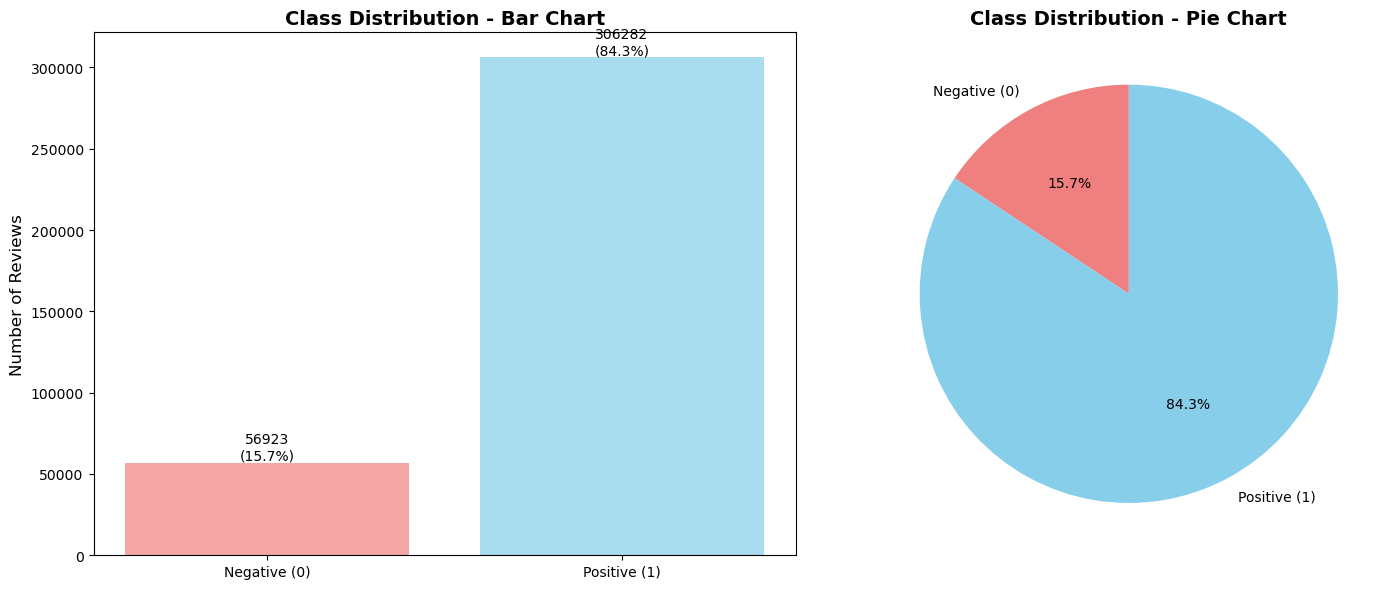


Dataset Status: Imbalanced
Imbalance degree: 68.66%

Future strategy recommendations:
1. Oversampling (e.g., SMOTE) - Create synthetic samples for minority class
2. Undersampling - Randomly remove samples from majority class
3. Class weights - Adjust loss function to penalize misclassification of minority class more
4. Collect more data for minority class


In [45]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
bars = ax1.bar(['Negative (0)', 'Positive (1)'], counts_per_label.values, 
               color=['lightcoral', 'skyblue'], alpha=0.7)
ax1.set_title('Class Distribution - Bar Chart', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Reviews', fontsize=12)

# Add value labels on bars
for bar, count in zip(bars, counts_per_label.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{count}\n({class_percentages[bar.get_x() + bar.get_width()/2.]:.1f}%)',
             ha='center', va='bottom')


# Pie chart
colors = ['lightcoral', 'skyblue']
ax2.pie(class_percentages, labels=['Negative (0)', 'Positive (1)'], 
        autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Class Distribution - Pie Chart', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Determine if dataset is balanced
balance_threshold = 5  # percentage difference threshold
is_balanced = abs(class_percentages[0] - class_percentages[1]) < balance_threshold

status = "Balanced" if is_balanced else "Imbalanced"
print(f"\nDataset Status: {status}")

if not is_balanced:
    imbalance_degree = abs(class_percentages[0] - class_percentages[1])
    print(f"Imbalance degree: {imbalance_degree:.2f}%")
    print("\nFuture strategy recommendations:")
    print("1. Oversampling (e.g., SMOTE) - Create synthetic samples for minority class")
    print("2. Undersampling - Randomly remove samples from majority class")
    print("3. Class weights - Adjust loss function to penalize misclassification of minority class more")
    print("4. Collect more data for minority class")

In [46]:
label_dist = {"Dataset":["Amazon"],"Positive %":[class_percentages[1]],"Negative %":[class_percentages[0]],"Status":["Balanced" if is_balanced else "Imbalanced"]}
df_label_dist = pd.DataFrame(label_dist)
df_label_dist

,Dataset,Positive %,Negative %,Status
0,Amazon,84.327584,15.672416,Imbalanced


------------

----------------

## 6. Train/Test Split

In [47]:
df_amazon = df_amazon[['label', 'cleaned_review']]
df_amazon.head()

,label,cleaned_review
0,1,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
1,0,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
2,1,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
3,0,looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal
4,1,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal


### Method 1: Split without balancing

In [48]:
# Split the whole dataset, stratified by 'label'
df_train, df_test = train_test_split(
    df_amazon, 
    test_size=0.2,        # 20% test, 80% train
    random_state=42,
    stratify=df_amazon['label']  # ensures same label distribution in train and test
)


# Train label counts with percentages
train_counts = df_train['label'].value_counts()
train_percent = (train_counts / train_counts.sum() * 100).round(2)
print("Train label counts (%):")
for label, count in train_counts.items():
    print(f"Label {label}: {count} ({train_percent[label]}%)")

# Test label counts with percentages
test_counts = df_test['label'].value_counts()
test_percent = (test_counts / test_counts.sum() * 100).round(2)
print("\nTest label counts (%):")
for label, count in test_counts.items():
    print(f"Label {label}: {count} ({test_percent[label]}%)")

Train label counts (%):
Label 1: 245026 (84.33%)
Label 0: 45538 (15.67%)

Test label counts (%):
Label 1: 61256 (84.33%)
Label 0: 11385 (15.67%)


In [49]:
df_train.to_csv("../../p1_data/splits/amazon_train_m1.csv", index=False)
df_test.to_csv("../../p1_data/splits/amazon_test_m1.csv", index=False)

### Method 2: Balancing the dataset (training set)

In [50]:
# Separate majority and minority classes
df_majority = df_train[df_train['label'] == 1]  # positive (majority)
df_minority = df_train[df_train['label'] == 0]  # negative (minority)


# Downsample majority to match minority
df_majority_down = resample(
    df_majority,
    replace=False,           # no replacement
    n_samples=int(len(df_minority) * 1.5), # downsample to (1.5 * minority size)
    random_state=42
)


# Oversample minority to increase size 
df_minority_up = resample(
    df_minority,
    replace=True,            # allow duplicates --> may lead to Overfitting, so I thin it's good to use downsampling only
    n_samples=len(df_majority_down),  # match the downsampled majority
    random_state=42
)


df_train_balanced = pd.concat([df_majority_down, df_minority_up])
df_train_balanced = df_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Count of each label
counts = df_train_balanced['label'].value_counts()

# Percentage of each label
percentages = (counts / counts.sum() * 100).round(2)

# Print counts with percentages
for label, count in counts.items():
    print(f"Label {label}: {count} ({percentages[label]}%)")


Label 1: 68307 (50.0%)
Label 0: 68307 (50.0%)


In [54]:
df_train_balanced.to_csv("../../p1_data/splits/amazon_train_m2.csv", index=False)

In [55]:
print(f"total removed records from the dataset is {total_removed_recordes} records")

total removed records from the dataset is 205249 records
